In [2]:
!pip install clip-benchmark>=1.4.0 datasets>=2.8.0 open-clip-torch>=2.20.0 timm>=0.9.5 coremltools


In [ ]:
#We clone MobileCLIP from: https://github.com/apple/ml-mobileclip
!git clone https://github.com/apple/ml-mobileclip.git

#Install MobileCLIP
%cd ml-mobileclip
!pip install -e . -q

In [4]:
#Download pretrained checkpoints
%mkdir -p checkpoints
!wget wget https://docs-assets.developer.apple.com/ml-research/datasets/mobileclip/mobileclip_s0.pt -P checkpoints

--2024-07-09 13:40:40--  http://wget/
Resolving wget (wget)... failed: Name or service not known.
wget: unable to resolve host address ‘wget’
--2024-07-09 13:40:40--  https://docs-assets.developer.apple.com/ml-research/datasets/mobileclip/mobileclip_s0.pt
Resolving docs-assets.developer.apple.com (docs-assets.developer.apple.com)... 17.253.27.201, 17.253.27.196, 2620:149:a23:f000::203, ...
Connecting to docs-assets.developer.apple.com (docs-assets.developer.apple.com)|17.253.27.201|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 215934653 (206M) [application/octet-stream]
Saving to: ‘checkpoints/mobileclip_s0.pt’

mobileclip_s0.pt    100%[===================>] 205.93M   150MB/s    in 1.4s    

2024-07-09 13:40:42 (150 MB/s) - ‘checkpoints/mobileclip_s0.pt’ saved [215934653/215934653]

FINISHED --2024-07-09 13:40:42--
Total wall clock time: 1.8s
Downloaded: 1 files, 206M in 1.4s (150 MB/s)


In [8]:
#Model inference with reparamerized model
import coremltools
import torch
import mobileclip
from mobileclip.modules.common.mobileone import reparameterize_model
from mobileclip.modules.text.tokenizer import (
    ClipTokenizer,
)
from mobileclip.clip import CLIP
from typing import Dict, Optional, Any
import json
import os
import numpy as np

# mobileclip_s0
model_cfg = {
    "embed_dim": 512,
    "image_cfg": {
        "image_size": 256,
        "model_name": "mci0"
    },
    "text_cfg": {
        "context_length": 77,
        "vocab_size": 49408,
        "dim": 512,
        "ffn_multiplier_per_layer": 4.0,
        "n_heads_per_layer": 8,
        "n_transformer_layers": 4,
        "norm_layer": "layer_norm_fp32",
        "causal_masking": False,
        "model_name": "mct"
    }
}

class CLIP_encode_text(CLIP):
    """Class for encoding text using the text encoder from CLIP."""

    def __init__(self, cfg: Dict, output_dict: bool = False, *args, **kwargs) -> None:
        super().__init__(cfg, output_dict, *args, **kwargs)

    def forward(self, text: Optional[torch.Tensor] = None) -> Any:
        text_embeddings = (
            self.encode_text(text, normalize=True) if text is not None else None
        )
        return text_embeddings


model_text = CLIP_encode_text(cfg=model_cfg)
model_text.eval()

chkpt = torch.load("checkpoints/mobileclip_s0.pt")
model_text.load_state_dict(chkpt)  #strict=False

reparameterized_model = reparameterize_model(model_text)
reparameterized_model.eval()

tokenizer = ClipTokenizer(model_cfg)
#text = tokenizer(["a diagram", "a dog", "a cat"]).to(torch.int32)
text = tokenizer(["a diagram"]).to(torch.int32)

text_tensor = torch.randint(0, tokenizer.get_vocab_size(), text.shape, dtype=torch.int32)

traced_model = torch.jit.trace(reparameterized_model, text_tensor)
traced_model.save("clip_text.pt")

input_tensor = [coremltools.TensorType(name="input_text", shape=text_tensor.shape, dtype=np.int32)]

ml_model = coremltools.convert(
        model=traced_model,
        outputs=None,
        inputs=input_tensor,
        convert_to="mlprogram",
        minimum_deployment_target=coremltools.target.iOS17,
        compute_units=coremltools.ComputeUnit.ALL,
        debug=True,
    )
ml_model.save("clip_text_s0.mlpackage")

Running MIL backend_mlprogram pipeline: 100%|██████████| 12/12 [00:00<00:00, 68.83 passes/s]


In [9]:
#Check CoreML Parameters:
spec = ml_model.get_spec()
print("model type: {}".format(spec.WhichOneof('Type')))
print("model description: {}".format(spec.description))
print("model inputs: {}".format(spec.description.input))
print("model outputs: {}".format(spec.description.output))

model type: mlProgram
model description: input {
  name: "input_text"
  type {
    multiArrayType {
      shape: 1
      shape: 77
      dataType: INT32
    }
  }
}
output {
  name: "var_476"
  type {
    multiArrayType {
      shape: 1
      shape: 512
      dataType: FLOAT16
    }
  }
}
metadata {
  userDefined {
    key: "com.github.apple.coremltools.source"
    value: "torch==1.13.1+cu117"
  }
  userDefined {
    key: "com.github.apple.coremltools.source_dialect"
    value: "TorchScript"
  }
  userDefined {
    key: "com.github.apple.coremltools.version"
    value: "7.2"
  }
}

model inputs: [name: "input_text"
type {
  multiArrayType {
    shape: 1
    shape: 77
    dataType: INT32
  }
}
]
model outputs: [name: "var_476"
type {
  multiArrayType {
    shape: 1
    shape: 512
    dataType: FLOAT16
  }
}
]


In [11]:
#Download mlpackage
import shutil
from google.colab import files
directory_path = 'clip_text_s0.mlpackage'
zip_path = 'clip_text_s0.mlpackage.zip'
shutil.make_archive(directory_path, 'zip', directory_path)
os.rename(f"{directory_path}.zip", zip_path)
files.download(zip_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

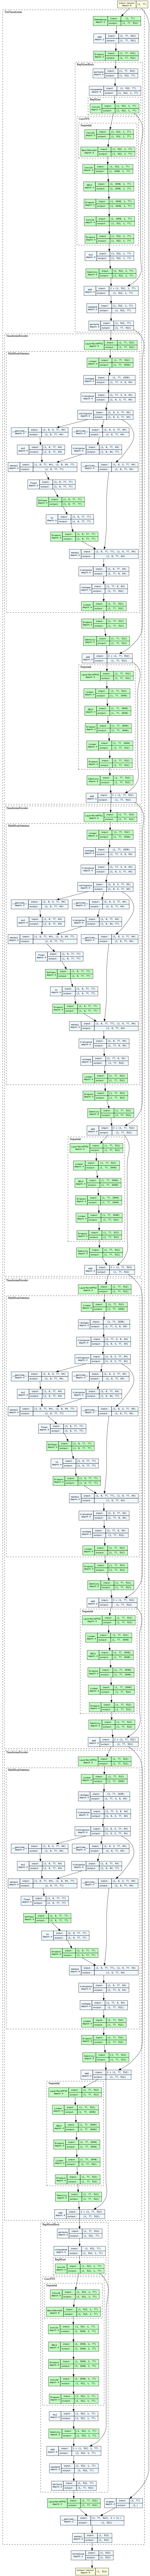

In [15]:
#Optional: Visualize the model
!pip install graphviz torchview
from torchview import draw_graph
import graphviz
graphviz.set_jupyter_format('png')
model_graph = draw_graph(reparameterized_model, input_data = text_tensor, expand_nested = True, depth = 5)
model_graph.visual_graph